In [1]:
# %pip install torchviz

In [2]:
"""this is just for me since gpu bugged"""
# %env CUDA_VISIBLE_DEVICES=1

'this is just for me since gpu bugged'

In [4]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
import torchvision.transforms as T
from skimage import transform as sktf
from skimage.util import random_noise
import random

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)
- added some transforms that are vert and hor flips including rotation
- [ ] TODO Add random noise shapes in the image outside the mask maybe that will help the model learn better

In [47]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_transforms=0,include_inverse_mask=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_transforms = num_transforms
        self.include_inverse_mask=include_inverse_mask
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data = []

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

          
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)/255.0
            # image = Image.fromarray(image)  

            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512,512))
            mask = (mask > 0.5).astype(np.float32) 
            # mask = Image.fromarray(mask)  #   PIL image needed for transforms

            # store the original image and mask
            self.append_image_mask(image, mask)

            # do transformations 
            for _ in range(self.num_transforms):
                transformed_image, transformed_mask = self.apply_transform(image, mask)
                self.append_image_mask(transformed_image, transformed_mask)

    def apply_transform(self, image, mask):
        """Apply deterministic transformations to both image and mask
        This is imortant since using the torchvision.transforms was givin a random transform
        for both image and mask -> they didn't match up"""
        if self.transform:
            
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

           
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            # Apply rotation deterministically
            angle = np.random.uniform(-30, 30)
            image = sktf.rotate(image, angle, mode="edge" , preserve_range=True)
            mask = sktf.rotate(mask, angle, mode="edge" , preserve_range=True)

        return image, mask

    def append_image_mask(self, image, mask):
        """need to store them as tensors."""
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) # (C, H, W)
        mask = torch.tensor(mask[None, ...], dtype=torch.float32)   # (1, H, W)

       
        if(self.include_inverse_mask):
            inverse_mask = 1 - mask
            combined_mask = torch.cat([inverse_mask, mask], dim=0)  # Combined (2, H, W)

        
            self.data.append((image, combined_mask))
        else:
            self.data.append((image,mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


Loading the training dataset
- NOTE increasing batch size to 5 since our dataset size is up to 40 now

40
torch.Size([2, 512, 512])


(<Axes: >, <matplotlib.image.AxesImage at 0x237ce8453d0>)

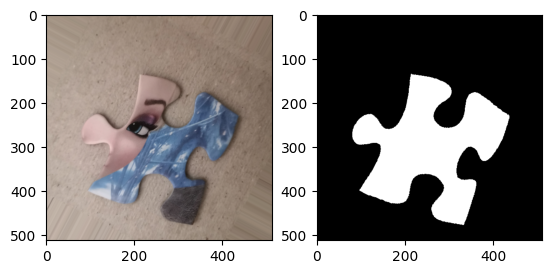

In [6]:
#  list of transformations
# transform_list = [
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip(),
#     T.RandomRotation(30),
# ]


train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3  
)
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
# note we now have more images since transform applied so maybe adjust batches
train_loader = DataLoader(train_dataset,batch_size =2, shuffle=True)

print(len(train_dataset.data))
# # to visualise the images + masks are in correct pairing
image, mask = train_dataset[6]

image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
mask_np = mask.permute(1, 2, 0).numpy()
print(mask.shape)


#to collapse the separate channels of bg and fg mask
if mask_np.shape[2] == 2:
    mask_np = np.argmax(mask_np, axis=2)
    
plt.figure()
plt.subplot(1,2,1), plt.imshow(image_np)
plt.subplot(1,2,2), plt.imshow(mask_np, cmap="gray")



In [7]:
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/", 
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)

# 3.1 Unet Construction
## Add notes on this here (what is happening)

In [6]:
""" Adding checkpoints as required and to avoid training everytime someone wants to test"""
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


# use as in training
"""save_checkpoint(model, optimizer, epoch)"""


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return epoch
    else:
        print("No checkpoint found.")
        return 0  # training from start ...

# before training starts to load model
"""start_epoch = load_checkpoint(model, optimizer)"""


'start_epoch = load_checkpoint(model, optimizer)'

In [7]:
""" helper to clear the gpu of datasets and model"""
def clear_gpu_memory(model=None, data_loaders=None):
    
    if model is not None:
        model.cpu()
        del model
    
    
    if data_loaders is not None:
        for loader in data_loaders:
            del loader  
    
    #  garbage collection
    gc.collect()
    
    torch.cuda.empty_cache()

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling
- We removed the softmax in the unet with convolve to get to the required number of output classes (ask richard).
- Having the argmax inside the network caused issues with backprop so we only compute the raw logits and use these for the BCE loss
then use the apply softmax outside when performing inference on the test set.

In [8]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)
    
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)

    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )

    def forward(self, x):
        ret_ = self.conv_pool(x)
        return ret_

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels,mode):
        super(Up, self).__init__()
        if(mode=='convtranspose'):
            self.conv_pool = nn.Sequential(
                UpConvTranspose(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        else:
            self.conv_pool = nn.Sequential(
                UpBilinear(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        
        self.dconv = DoubleConv(out_channels*2,out_channels)
    
    def forward(self,x1,x2):
        x = self.conv_pool(x1)
        return self.dconv(torch.cat([x,x2],dim=1))

    
class SoftMax(nn.Module):
    def __init__(self, in_channels):
        super(SoftMax, self).__init__()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)
        return torch.argmax(x,dim=1)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant='convtranspose'):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)
        
        self.up1 = Up(1024,512,variant)
        self.up2 = Up(512, 256,variant)
        self.up3 = Up(256, 128,variant)
        self.up4 = Up(128, 64,variant)

        self.outc = nn.Conv2d(64,2, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits
    

In [9]:
def calculate_iou(preds, targets, threshold=0.5):
    # Make sure predictions and targets are 4D: [batch_size, channels, height, width]
    if preds.dim() == 3:
        preds = preds.unsqueeze(0)  # Add batch dimension
    if targets.dim() == 3:
        targets = targets.unsqueeze(0)  # Add batch dimension

    preds = (torch.sigmoid(preds) > threshold).float()
    
    # Calculate intersection and union
    intersection = torch.sum(preds * targets, dim=[2, 3])
    union = torch.sum(preds, dim=[2, 3]) + torch.sum(targets, dim=[2, 3]) - intersection
    
    # Calculate IoU
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add small epsilon to avoid division by zero
    
    return iou.mean().item()


NOTE: I just pushed to the cpu when I try putting the model on the gpu I get weird errors in training 
that I used up all the GPU memory maybe you wont get this error then just comment out `device="cpu"
`

In [10]:
""" Training UNET Variant 1
    torch.nn.ConvTranspose2d """

import gc
import wandb
wandb.init(project="Unet variant 1")

# I forced the device to cpu since I have no gpu comment that line out!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")



# Model, criterion, and optimizer setup
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var1_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou += train_iou/ len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou += calculate_iou(torch.sigmoid(outputs), masks)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model,optimizer, epoch, "var1_checkpoint.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())


# close wandb run


# run tensorboard --logdir=runs to see networkls


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 2322203 (2322203-witwatersrand-university). Use `wandb login --relogin` to force relogin


Device: cuda
No checkpoint found.
Epoch [1/50], Loss: 0.6240899056196213
Checkpoint saved at epoch 0.
Checkpoint saved at epoch 1
Epoch [2/50], Loss: 0.5312120348215104
Checkpoint saved at epoch 1.
Checkpoint saved at epoch 2
Epoch [3/50], Loss: 0.45510374307632445
Checkpoint saved at epoch 2.
Checkpoint saved at epoch 3
Epoch [4/50], Loss: 0.4024785742163658
Checkpoint saved at epoch 3.
Checkpoint saved at epoch 4
Epoch [5/50], Loss: 0.3681014463305473
Epoch [6/50], Loss: 0.34176681786775587
Epoch [7/50], Loss: 0.32887920290231704
Epoch [8/50], Loss: 0.31266810595989225
Epoch [9/50], Loss: 0.3014374881982803
Epoch [10/50], Loss: 0.2942566856741905
Epoch [11/50], Loss: 0.2885154977440834
Checkpoint saved at epoch 10.
Checkpoint saved at epoch 11
Epoch [12/50], Loss: 0.2826685443520546
Checkpoint saved at epoch 11.
Checkpoint saved at epoch 12
Epoch [13/50], Loss: 0.277421872317791
Epoch [14/50], Loss: 0.27506391108036043
Checkpoint saved at epoch 13.
Checkpoint saved at epoch 14
Epoch 

In [11]:
def display_tensor_as_image(tensor, channel_num, channel_index, height_index, width_index):
    # Move the tensor to CPU and convert it to a NumPy array
    tensor_np = tensor.cpu().numpy()
    if channel_index == 1:
        tensor_np = tensor_np.squeeze(0)

        channel_index -=1
        height_index-=1
        width_index-=1
        
    # Handle single-channel (grayscale) image
    if channel_num == 1:
        image_np = tensor_np.squeeze(channel_index)  # Remove the channel dimension
        plt.imshow(image_np, cmap="gray")
        plt.title("Single-channel image")
        plt.show()
    
    # Handle two-channel image (display channels separately)
    elif channel_num == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        for i in range(2):
            channel_image = tensor_np[i]  # Select each channel (e.g., 0 and 1)
            axes[i].imshow(channel_image, cmap="gray")
            axes[i].set_title(f"Channel {i}")
            # print(f"Max value in channel {i}:", np.max(channel_image))
            # print(f"Min value in channel {i}:", np.min(channel_image))
        plt.show()
    
    # Handle three-channel image (RGB)
    elif channel_num == 3:
        print(tensor_np.shape)
        # Transpose from (channels, height, width) to (height, width, channels)
        image_np = np.transpose(tensor_np, (height_index, width_index, channel_index))
        plt.imshow(image_np)
        plt.title("Three-channel image (RGB)")
        plt.show()


In [12]:
def evaluate_model_on_test_loader(model, test_loader, device, show_plot=False):
    model.eval() 
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for image, mask in test_loader:
            images = image.to(device)
            masks = mask.to(device)  
            
            outputs = model(images)
            #  softmax
            probs = torch.softmax(outputs, dim=1)

            #  predicted mask
            predicted_mask = torch.argmax(probs, dim=1)  #dim=1 for batch predictions

            # IoU for the current batch
            total_iou += calculate_iou(predicted_mask, masks) 
            num_samples += 1

            if show_plot:
                display_tensor_as_image(images, 3, 1, 2, 3)
                image_np = predicted_mask.squeeze().cpu().numpy()
                plt.imshow(image_np, vmin=0, vmax=1, cmap='gray')
                plt.axis('off')  
                plt.show()

    mean_iou = total_iou / num_samples if num_samples > 0 else 0
    print(f"Mean IoU on the test set: {mean_iou:.4f}")
    
    # mean IoU to wandb
    # wandb.log({"test_mean_iou": mean_iou})
    
    return mean_iou

(3, 512, 512)


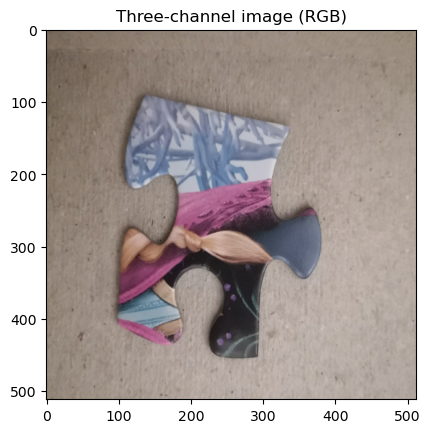

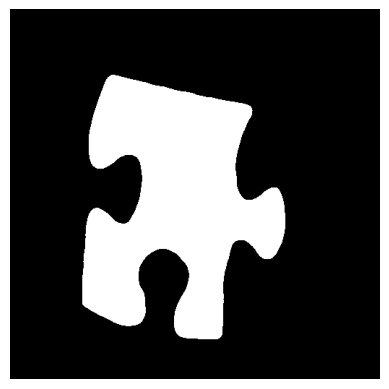

(3, 512, 512)


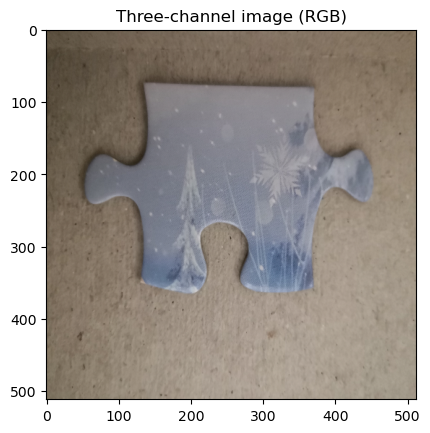

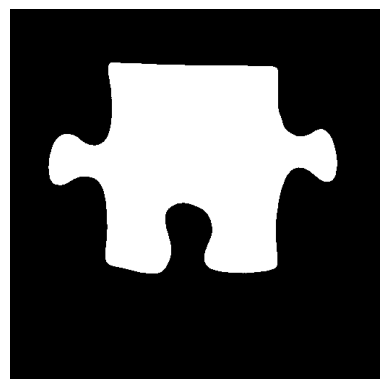

(3, 512, 512)


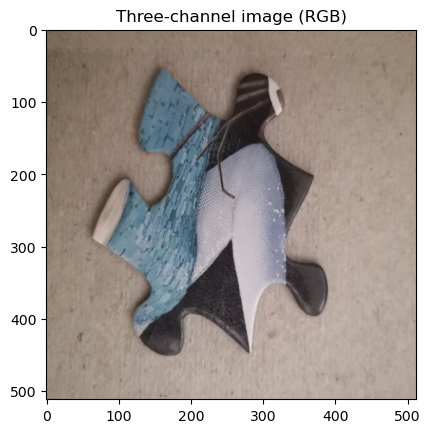

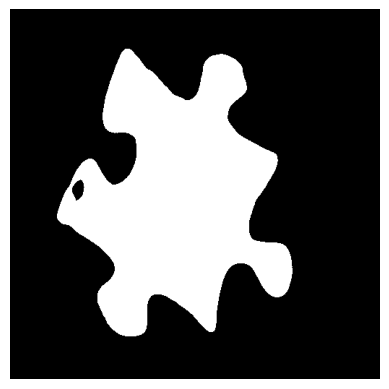

(3, 512, 512)


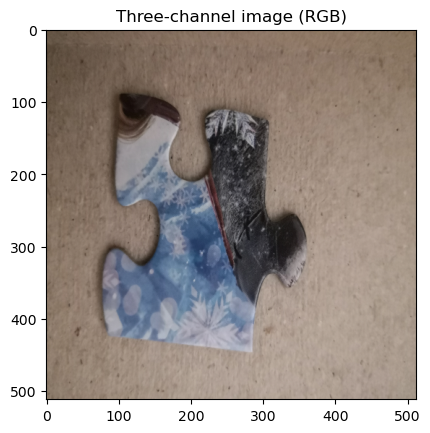

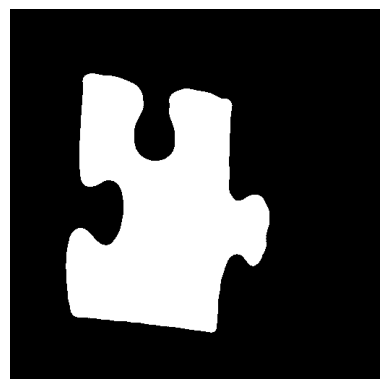

Mean IoU on the test set: 0.4924


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_mean_iou,▁
train_iou,▁▄▆▇▇███████████████████████████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▃▇█▇▆▆▇▇▇▇█▆▆▆▇█▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇
val_loss,█▆▄▃▃▃▄▄▄▃▄▂▅▄▅▂▂▃▃▄▄▁▄▄▂▁▁▂▂▃▂▃▃▂▃▃▃▃▃▃
epoch,49
test_mean_iou,0.49239
train_iou,20.8389
train_loss,0.21146
val_iou,3.88994


In [13]:

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

In [14]:

wandb.init(project="Unet variant 2 - bilinear upsampling")


model = Unet(n_channels=3, n_classes=2)

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var2_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou += train_iou/ len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou += calculate_iou(torch.sigmoid(outputs), masks)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"var2_checkpoint.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())




No checkpoint found.
Epoch [1/50], Loss: 0.6744918137788772
Checkpoint saved at epoch 1
Epoch [2/50], Loss: 0.581272691488266
Checkpoint saved at epoch 2
Epoch [3/50], Loss: 0.5033203229308129
Checkpoint saved at epoch 3
Epoch [4/50], Loss: 0.4400369018316269
Checkpoint saved at epoch 4
Epoch [5/50], Loss: 0.39768285006284715
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.3691511169075966
Checkpoint saved at epoch 6
Epoch [7/50], Loss: 0.3501940444111824
Epoch [8/50], Loss: 0.33676952719688413
Checkpoint saved at epoch 8
Epoch [9/50], Loss: 0.3246213272213936
Checkpoint saved at epoch 9
Epoch [10/50], Loss: 0.31619898825883863
Epoch [11/50], Loss: 0.31047058701515196
Checkpoint saved at epoch 11
Epoch [12/50], Loss: 0.3047892704606056
Checkpoint saved at epoch 12
Epoch [13/50], Loss: 0.30005776286125185
Epoch [14/50], Loss: 0.29644801914691926
Epoch [15/50], Loss: 0.29270332157611845
Epoch [16/50], Loss: 0.28955153524875643
Epoch [17/50], Loss: 0.28628451824188234
Epoch [18/50], Los

(3, 512, 512)


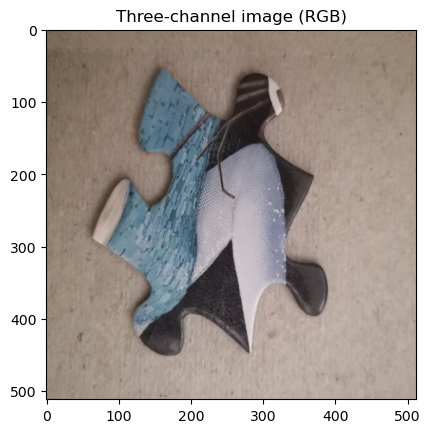

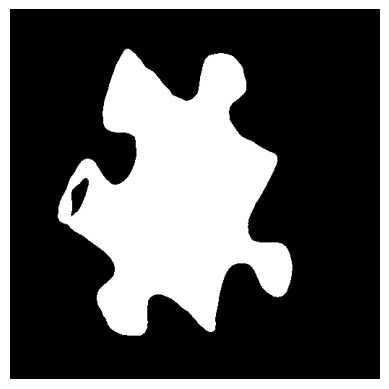

(3, 512, 512)


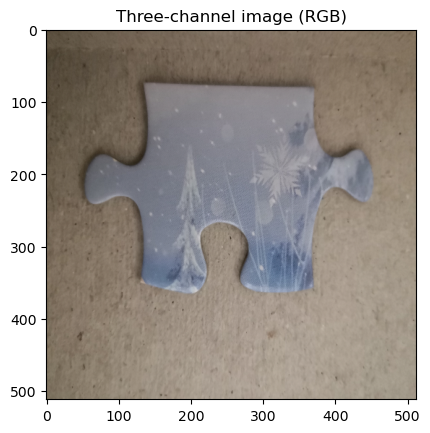

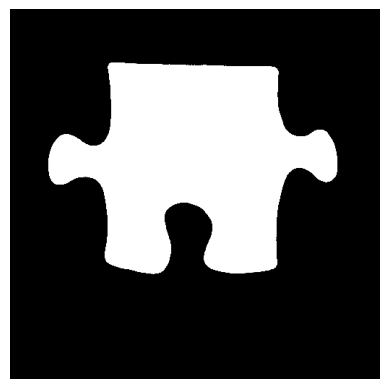

(3, 512, 512)


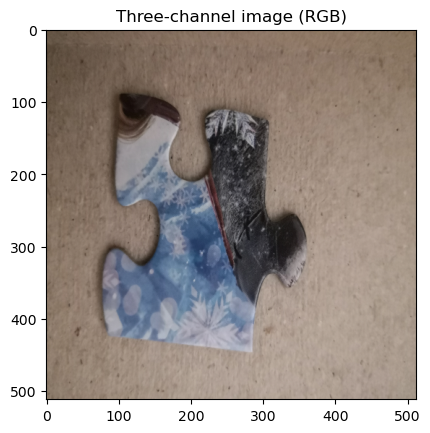

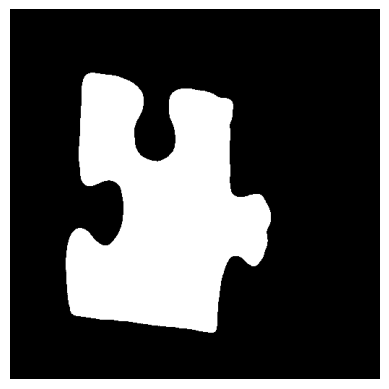

(3, 512, 512)


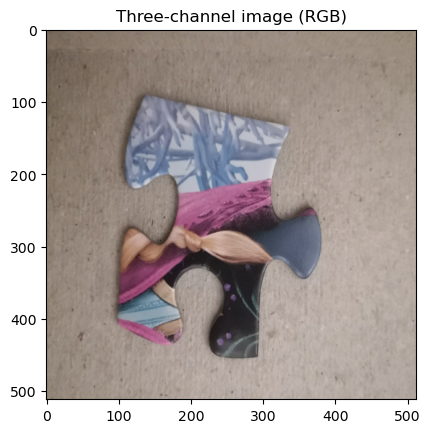

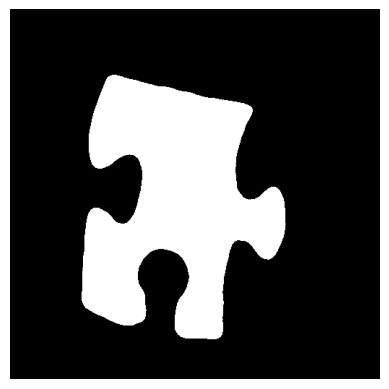

Mean IoU on the test set: 0.4916


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
test_mean_iou,▁
train_iou,▁▄▆▇▇███████████████████████████████████
train_loss,█▇▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▄▇▆▆▆▇█▇█▇▇▆▆▆█▇▇▇▆▇▆▇█▅█▇█▇▇▇▇▅▆▆█▇▇██
val_loss,█▅▄▄▃▃▂▃▂▂▃▂▄▃▄▂▂▂▃▃▂▂▁▅▂▂▂▂▂▂▂▂▅▄▃▁▃▃▁▁
epoch,49
test_mean_iou,0.4916
train_iou,20.82242
train_loss,0.23609
val_iou,4.35558


In [15]:
test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


# 3.2 Training and evaluation 
### Training
- [x] Implement the training loop with binary cross entropy loss for pixel-wise classification
- [x] Adam Optimiser to update the model parameters
**Note** have regularly saved checkpoints and evaluate model in the validation set to avoid over fitting

### Weights and biases integration
Log the following:
- [x] Track BCE loss over epochs
- [x] IoU for both training and validation sets to monitor the segmentation performance

### Need to submit from the wandb dashboard
- Loss curves (training and validation over epochs)
- IoU curves (training and validation over epochs)

### Remember to comment on comment on whether the model is overfitting and how to recognise this and deal with the problem

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU

# Select the best model based on the validation IoU and report its performance on the test set

# 4 Other architectures


In [3]:
#!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
#!pip install lightning albumentations

  Using cached numpy-2.1.1-cp311-cp311-win_amd64.whl.metadata (59 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/811.0 kB ? eta -:--:--
   ---------------------------------------- 811.0/811.0 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
    --------------------------------------- 0.8/38.8 MB 4.8 MB/s eta 0:00:08
   - -------------------------------------- 1.6/38.8 MB 4.0 MB/s eta 0:00:10
   -- ------------------------------------- 2.1/38.8 MB 3.6 MB/s eta 0:00:11
   -- ------------------------------------- 2.6/38.8 MB 3.2 MB/s eta 0:00:12
   --- ------------------------------------ 3.4/38.8 MB 3.4 MB/s eta 0:00:11
   ---- ----------------------------------- 4.2/38.8 MB 3.3 MB/s eta 0:00:11
   ----- ---------------------------------- 5.0/38.8 MB 3.4 MB/s eta 0:00:10
   ----- ----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.


In [8]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.optim import lr_scheduler

c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3,
    include_inverse_mask=False 
)
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/",
    include_inverse_mask=False
)

test_dataset = PuzzleDataset(
    img_dir = "./images-1024x768/test/",
    mask_dir = "./masks-1024x768/test/",
    include_inverse_mask=False

)

train_dataloader = DataLoader(train_dataset,batch_size=5,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=5,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [65]:
EPOCHS = 10
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

class UnetPlus(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        #print("batch:",batch[0].shape)
        image, mask = batch
        #image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        #mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        #print(f"Logits mask shape: {logits_mask.shape}, Target mask shape: {mask.shape}")


        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

### 1. Resnet 34

In [66]:
UnetRes = UnetPlus("Unet","resnet34",3,1)

In [68]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetRes,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | UnetPlusPlus | 26.1 M | train
1 | loss_fn | DiceLoss     | 0      | train
-------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.314   Total estimated model params size (MB)
267       Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 8/8 [04:48<00:00,  0.03it/s, v_num=15, valid_per_image_iou=0.939, valid_dataset_iou=0.940, train_per_image_iou=0.932, train_dataset_iou=0.932]

OSError: [Errno 28] No space left on device

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetRes, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetRes, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
#Save model
smp_model = UnetRes.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus",
)

In [ ]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### 2. Unet VGG

In [71]:
UnetVGG = UnetPlus("Unet","vgg11",3,1)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\Oriin/.cache\torch\hub\checkpoints\vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [04:51<00:00, 1.82MB/s]


In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetVGG,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetVGG, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetVGG, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
#Save model
smp_model = UnetVGG.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus",
)

In [ ]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### 3. Unet EfficientNet

In [73]:
UnetEff = UnetPlus("Unet","efficientnet-b7",3,1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to C:\Users\Oriin/.cache\torch\hub\checkpoints\efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [04:11<00:00, 1.06MB/s]


In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetEff,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetEff, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetVGG, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
#Save model
smp_model = UnetEff.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus",
)

In [ ]:
# Display and compare with Ground truth
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break